In [1]:
from remote_vgk import *
from buffet import (
    buffet_classification
)

import numpy as np
import matplotlib.pyplot as plt

def load_password(path):

    with open(path) as f:
        secrets = json.load(f)
        shifted_pwd = secrets['password']
    pwd = ''
    for s in shifted_pwd:
        pwd += chr(ord(s) - 1)

    return pwd

In [2]:
try:
    window = gw.getWindowsWithTitle("millenicut:19")[0]
except IndexError:
    raise Exception("Window not found")

pwd = load_password('secrets.json')
sesh = DPO_Session('lwp26', pwd)

App = AirfoilApp(sesh.teaching_client, window, "2.3_incidence_aerofoil")

# IMPORTANT SET THE SAME PARAMETERS AS ON THE APP
App.alpha = 1.75
App.M = 0.76
App.Re = 10

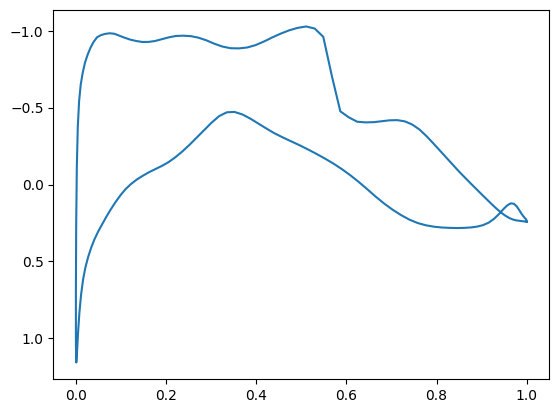

In [3]:

res = App.run(0.77, 1.9, 10)

plt.plot(res.x, res.cp)

# flip y axis
plt.gca().invert_yaxis()


In [4]:
print(res.Cl, res.Cd, res.CD2)

0.59949 0.01379 0.0049700000000000005


In [5]:

#App.classify_buffeting()

4684


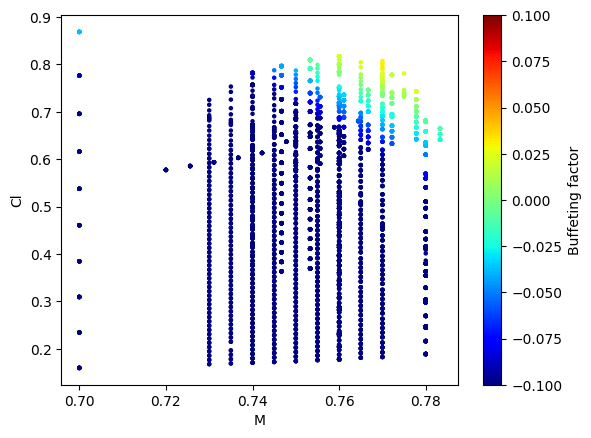

In [7]:

# scatter plot

fig, ax = plt.subplots()

Cl_list = []
M_list = []
alpha_list = []

for res in App:
    
    Cl_list.append(res.Cl)
    M_list.append(res.M)
    alpha_list.append(res.alpha)

buffeting_list = np.nan*np.ones(len(Cl_list))
i = 0
for res in App:
    if len(res.buffet_causes) > 0:
        buffeting_list[i] = res.buffet_causes[2]
    i += 1

print(len(buffeting_list))

scat = ax.scatter(M_list, Cl_list, c=buffeting_list, s = 5, cmap='jet', vmin=-0.1, vmax=0.1)
ax.set_ylabel('Cl')
ax.set_xlabel('M')
# create colourbar

# center colourbar on 0
cbar = plt.colorbar(scat, cmap = 'jet')
cbar.set_label('Buffeting factor')

plt.savefig('figures/buffeting_classification.png')
plt.show()
